In [36]:
'''
author: Felix Hol
date: 2019 July 22
content: code to track mosquitoes, several filtering parameters will need tweaking depending on imaging parameters.
Output is:
1) a pickle containing all detected centroids per frame
2) a pickle containing centroids tracked over time (/frame)
'''

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
# %matplotlib inline
# import matplotlib as mpl
# import matplotlib.pyplot as plt
import os
import itertools as it
import pandas as pd
import pims
import skimage
from skimage import data, io, util
from skimage.measure import label, regionprops
from skimage.morphology import binary_dilation, erosion, dilation, opening, binary_closing, closing, white_tophat, remove_small_objects, disk, black_tophat, skeletonize, convex_hull_image
import scipy
import trackpy as tp
import pylab
import math
from joblib import Parallel, delayed
import multiprocessing
from datetime import datetime
from tqdm import tnrange, tqdm
import pickle
import glob
import cv2 as cv

In [30]:
#### set directories where to get images and where to store output, and specifics of experiment

dataDir = '/Users/felix/Documents/mosquitoes/mosquitoData/smallTest/'
saveDir = '/Users/felix/biteOscope_test/test/dump/'
species = 'alb'
mosAge = 0      #### mosquito age in days
mosDataName = 'test'
frames = pims.ImageSequence(dataDir+'/*.tif', as_grey=True)
borderToExclude = 0           #### excludes the outer n pixels of the frame (in both x and y)
startFrame = 1              #### frame to start processing
stopFrame = len(frames)               #### frame to stop processing
startFrameBG = 1              #### frame to start background image
stopFrameBG = len(frames)     #### frame to stop background image (usually last frame unless immobile mosquitoes)
numBGframes = 20            #### number of frames to use for background image
mThreshold = 100              #### threshold used to create binary image of mosquitoes after BG subtraction
searchRadius = 600            #### used for tracking, maximum movement allowed between frames

In [28]:
#### create background image (BG image can be updated periodically - usually not necessary)

def getBG(start, stop, step):
    numBGframes = int(np.ceil((stop - start) /step) + 1)
    frameSize = frames[1].shape
    BG = np.zeros([frameSize[0], frameSize[1], numBGframes])

    j = 1
    for i in range(start, stop, step):
        j += 1
        BG[:, :, j - 1] = np.invert(frames[i])    
    BG = np.median(BG, axis=2)
    return BG

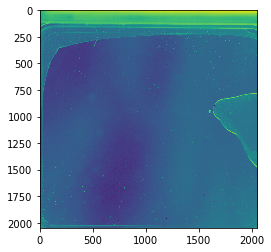

In [29]:
### compute background image using 30 frames (uniformly distributed over start - stop background)
### check resulting image to make sure non-moving mosquitoes did not become part of BG image

BG = getBG(startFrameBG, stopFrameBG, int(stopFrameBG / numBGframes)) 
plt.imshow(BG)

In [31]:
def trackMosq2(i, mThreshold, borderToExclude):
    frameSize = frames[1].shape
    # borderToExclude = 0
    selem1 = disk(8)
    selem2 = disk(1)
    A = np.zeros(frameSize)
    A = A + np.invert(frames[i])
    B = A - BG
    if B.min() > 0:
        Bm = B - B.min()
    else:
        Bm = B
    Bt = Bm > mThreshold
    Bts = remove_small_objects(Bt, min_size=400)
    Be = erosion(Bts, selem2)
    Bf = remove_small_objects(Be, min_size=300)
    Bc = binary_closing(Bf, selem1)
    C = B * Bc
    eroded = erosion(C, selem2)
    eroded = skimage.filters.gaussian(eroded, 4)
    eroded[eroded < 0] = 0
    erL = label(eroded>0)
    erR = regionprops(erL, C)#, coordinates='xy')
    l = 1
    for props in erR:   #### this filters out objects that are way too larger or small and excludes detections near the edge when desired
        if props.area > 50000:
            erL[erL==l] = 0
        if props.area < 1000:
            erL[erL==l] = 0
        if props.major_axis_length > 3000:
            erL[erL==l] = 0
        if props.centroid[0] < borderToExclude or props.centroid[1] < borderToExclude or props.centroid[0] > frameSize[0] - borderToExclude or props.centroid[1] > frameSize[1] - borderToExclude:
            erL[erL==l] = 0
        l = l +1
    erLf = label(erL>0)
    erodedF = eroded * (erLf > 0)
    erRf = regionprops(erLf, C)#, coordinates='xy')
    centroids = np.zeros([len(erRf), 2])
    numCent = 0
    for props in erRf:
        centroids[numCent] = props.centroid
        numCent += 1
    cenS= centroids.shape; numCen = cenS[0]
    frameNo = i
    frameNoCen = np.zeros((numCen,1), dtype=np.int)
    frameNoCen[:] = frameNo
    centroidsF = np.hstack((centroids,frameNoCen))
    numCents = centroidsF.shape[0]
    return centroidsF, numCents

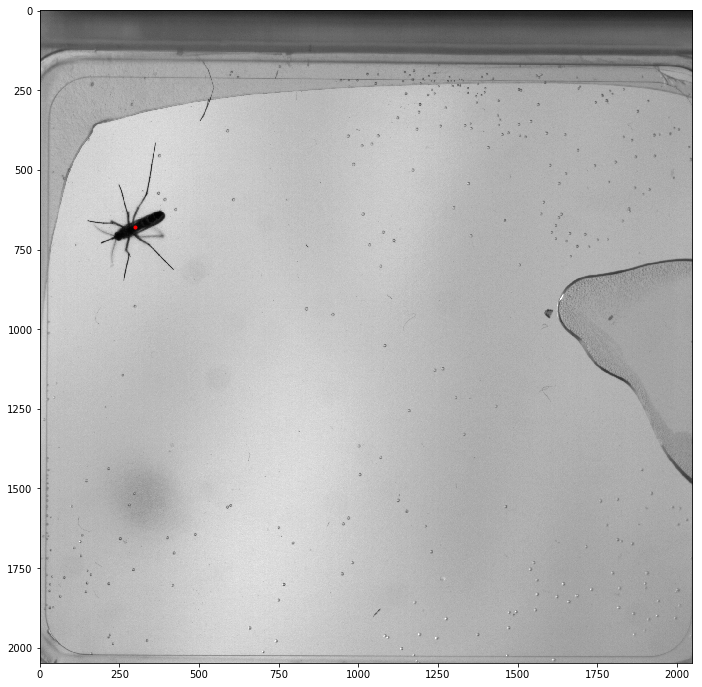

In [34]:
#####testing...., use this cell to check a few frames and verify that all mosquitoes are detected (red dot)
i = 20
centroidsF, numCents = trackMosq2(i, mThreshold, borderToExclude)
plt.figure(figsize=(18,12))
plt.imshow(frames[i], cmap = 'gray')
# plt.imshow(eroded)
# plt.plot(coordinatesF[:,1],coordinatesF[:,0],'r.')
plt.plot(centroidsF[:,1],centroidsF[:,0],'r.')

In [35]:
centroidsAllT = np.zeros((1,3))
num_cores = multiprocessing.cpu_count()

print('detecting centriods of mosquitoes in frames ' + str(startFrame) + ' - ' + str(stopFrame) + ' using ' + str(num_cores) + ' cores')

results = Parallel(n_jobs=num_cores)(delayed(trackMosq2)(i, mThreshold, borderToExclude) for i in tqdm(range(startFrame, stopFrame)))

centroidsAllT = np.zeros((1,3))

for i in range(len(results)):
    centroidsAllT = np.vstack((centroidsAllT,results[i][0]))

centroidPickleName = saveDir + mosDataName + '_centroids.pkl'
    
with open(centroidPickleName, 'wb') as f:
    pickle.dump(centroidsAllT, f)
    
### convert centroids to dataframe

df_cenAllT = pd.DataFrame(centroidsAllT)
df_cenAllT = df_cenAllT.rename(columns={0: "y", 1: "x", 2: "frame"})

### track (link mosquitoes across frames). Adjust search radius depending on how crowded the images are

print('linking centroids through time using search radius: ' + str(searchRadius))

tFull = tp.link_df(df_cenAllT, searchRadius, memory=3)

tFull['species'] = species
tFull['age'] = mosAge

tFull = tFull.drop([0])

trackPickleName = saveDir + mosDataName + '_tracks.pkl'
tFull.to_pickle(trackPickleName)

print('output saved at ' + saveDir)

Frame 24: 1 trajectories present
output saved at /Users/felix/biteOscope_test/test/dump/
